In [6]:
import cv2
from cv2 import aruco
import os
import numpy as np
import matplotlib.pyplot as plt

### New API (we don't use that)

In [4]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard((6, 4), 1, 0.5, aruco_dict)

In [5]:
imboard = board.generateImage((2000, 2000))

AttributeError: 'cv2.aruco.CharucoBoard' object has no attribute 'generateImage'

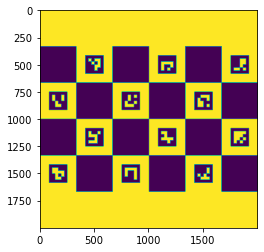

In [4]:
plt.imshow(imboard)
plt.show()

### Old API

In [9]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
# board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
board = aruco.CharucoBoard_create(6, 4, 1, 0.5, aruco_dict)
imboard = board.draw((2000, 2000))

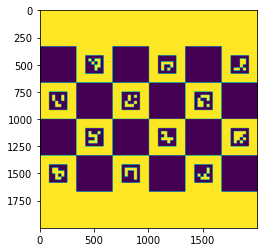

In [10]:
plt.imshow(imboard)
plt.show()

In [11]:
datadir_left = "./images/left/calibration/"
datadir_front = "./images/front/calibration/"
datadir_right = "./images/right/calibration/"

images_left = np.array([datadir_left + f for f in os.listdir(datadir_left) if f.endswith(".JPG") ])
images_front = np.array([datadir_front + f for f in os.listdir(datadir_front) if f.endswith(".JPG") ])
images_right = np.array([datadir_right + f for f in os.listdir(datadir_right) if f.endswith(".JPG") ])
# order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
# images = images[order]

In [12]:
images_left

array(['./images/left/calibration/GOPR0068.JPG',
       './images/left/calibration/GOPR0064.JPG',
       './images/left/calibration/GOPR0070.JPG',
       './images/left/calibration/GOPR0066.JPG',
       './images/left/calibration/GOPR0065.JPG',
       './images/left/calibration/GOPR0067.JPG',
       './images/left/calibration/GOPR0069.JPG'], dtype='<U38')

In [13]:
images_left = images[1:3]

NameError: name 'images' is not defined

=> Processing image ./images/left/calibration/GOPR0068.JPG
0


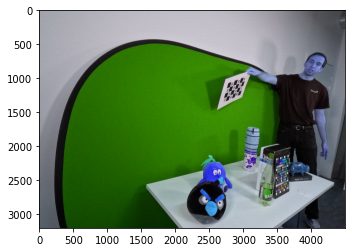

=> Processing image ./images/left/calibration/GOPR0064.JPG
0


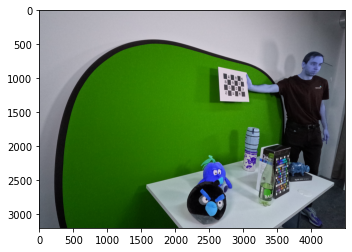

=> Processing image ./images/left/calibration/GOPR0070.JPG
12


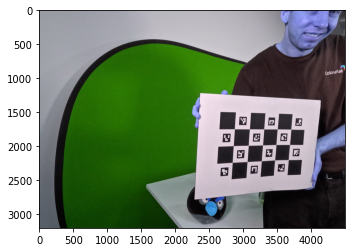

=> Processing image ./images/left/calibration/GOPR0066.JPG
0


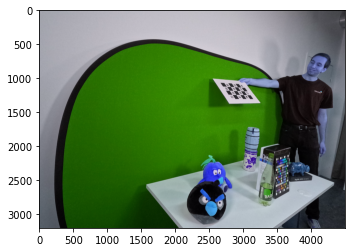

=> Processing image ./images/left/calibration/GOPR0065.JPG
0


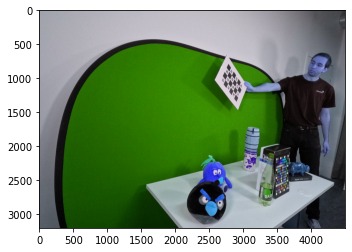

=> Processing image ./images/left/calibration/GOPR0067.JPG
0


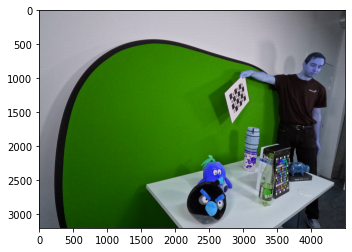

=> Processing image ./images/left/calibration/GOPR0069.JPG
0


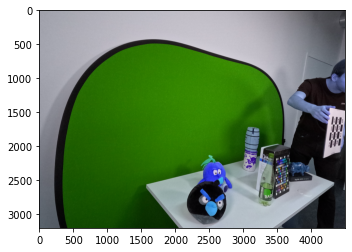

In [14]:
for i, im in enumerate(images_left):
    print("=> Processing image {0}".format(im))
    frame = cv2.imread(im)

    # front
#     frame = frame[1500:4000, 500:4500, :]

    # left
#     frame = frame[1500:4200, 2000:5000, :]
    
    # right
#     frame = frame[1000:3500, 1000:4000, :]

    frame = frame[1000:4200, 500:5000, :]

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print(len(corners))
    
#     img = aruco.drawDetectedMarkers(
#             image=frame, 
#             corners=corners)
    plt.imshow(frame)
    plt.show()
        

In [15]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         corners, ids, rejectedImgPoints =detector.detectMarkers(gray)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

        decimator+=1

    imsize = gray.shape
    return allCorners,allIds,imsize

In [16]:
allCorners_left, allIds_left, imsize_left=read_chessboards(images_left)

=> Processing image ./images/left/calibration/GOPR0068.JPG
=> Processing image ./images/left/calibration/GOPR0064.JPG
=> Processing image ./images/left/calibration/GOPR0070.JPG
=> Processing image ./images/left/calibration/GOPR0066.JPG
=> Processing image ./images/left/calibration/GOPR0065.JPG
=> Processing image ./images/left/calibration/GOPR0067.JPG
=> Processing image ./images/left/calibration/GOPR0069.JPG


In [17]:
def calibrate_camera(allCorners,allIds,imsize):
    """
    Calibrates the camera using the dected corners.
    """

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
#     flags = (cv2.CALIB_RATIONAL_MODEL)
    
#     (ret, camera_matrix, distortion_coefficients0,
#      rotation_vectors, translation_vectors,
#      stdDeviationsIntrinsics, stdDeviationsExtrinsics,
#      perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
#                       charucoCorners=allCorners,
#                       charucoIds=allIds,
#                       board=board,
#                       imageSize=imsize,
#                       cameraMatrix=cameraMatrixInit,
#                       distCoeffs=distCoeffsInit,
#                       flags=flags,
#                       criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    
    ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors = aruco.calibrateCameraCharuco(
        charucoCorners=allCorners,
        charucoIds=allIds,
        board=board,
        imageSize=imsize,
        cameraMatrix=cameraMatrixInit,
        distCoeffs=None,
        flags=flags,
        criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [18]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners_left,allIds_left,imsize_left)

In [36]:
mtx

array([[9.91021143e+02, 0.00000000e+00, 2.37524273e+03],
       [0.00000000e+00, 9.91021143e+02, 2.56454232e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [224]:
ret

1.3422286120260092

### Camera (hero11) parameters

In [ ]:
2.7mm - fl

In [ ]:
6.40 x 5.60 - sensor size

In [ ]:
5568*4872 - pixels

In [193]:
2.7*(1/(5.6/4872))

2349.0

## Extrinsic parameters

First, we'll try estimatePoseSingleMarkers

In [32]:
A4length = 297 # mm
number_of_squares = 6
aruco_size_factor = 0.5

size_of_marker = A4length*aruco_size_factor/(number_of_squares*1000)
for i in range(len(images_left)):
    frame = cv2.imread(images_left[i])
    imgaxis = aruco.estimatePoseSingleMarkers(allCorners_left[0][0], size_of_marker , mtx, dist)

error: OpenCV(4.6.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:831: error: (-215:Assertion failed) ( (npoints >= 4) || (npoints == 3 && flags == SOLVEPNP_ITERATIVE && useExtrinsicGuess) || (npoints >= 3 && flags == SOLVEPNP_SQPNP) ) && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPGeneric'


In [27]:
np.squeeze(allCorners_left[0],axis=1).shape

(15, 2)

### Load images of all 
Second, we try... ehm

In [59]:
datadirs = ["./images/left/calibration/","./images/front/calibration/","./images/right/calibration/"]
data = []
for i, ddir in enumerate(datadirs):
    
    data.append([ddir + f for f in os.listdir(ddir) if f.endswith(".JPG") ])
    data[-1].sort()
    
data

[['./images/left/calibration/capture1.JPG',
  './images/left/calibration/capture2.JPG',
  './images/left/calibration/capture3.JPG',
  './images/left/calibration/capture4.JPG',
  './images/left/calibration/capture5.JPG',
  './images/left/calibration/capture6.JPG',
  './images/left/calibration/capture7.JPG'],
 ['./images/front/calibration/capture1.JPG',
  './images/front/calibration/capture2.JPG',
  './images/front/calibration/capture3.JPG',
  './images/front/calibration/capture4.JPG',
  './images/front/calibration/capture5.JPG',
  './images/front/calibration/capture6.JPG',
  './images/front/calibration/capture7.JPG'],
 ['./images/right/calibration/capture1.JPG',
  './images/right/calibration/capture2.JPG',
  './images/right/calibration/capture3.JPG',
  './images/right/calibration/capture4.JPG',
  './images/right/calibration/capture5.JPG',
  './images/right/calibration/capture6.JPG']]

### Camera calibration

In [66]:
cam_calibrations = []
for cam in data:
    allCorners, allIds, imsize = read_chessboards(cam)
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)
    print(aruco.estimatePoseCharucoBoard(allCorners[0],allIds[0],board, mtx, dist, rvecs[0], tvecs[0]))
    cam_calibrations.append([ret,mtx,dist,rvecs,tvecs])

=> Processing image ./images/left/calibration/capture1.JPG
=> Processing image ./images/left/calibration/capture2.JPG
=> Processing image ./images/left/calibration/capture3.JPG
=> Processing image ./images/left/calibration/capture4.JPG
=> Processing image ./images/left/calibration/capture5.JPG
=> Processing image ./images/left/calibration/capture6.JPG
=> Processing image ./images/left/calibration/capture7.JPG
(True, array([[ 0.04845307],
       [-0.10248622],
       [ 0.0171072 ]]), array([[ 2.9545296 ],
       [-0.29485656],
       [ 3.82615849]]))
=> Processing image ./images/front/calibration/capture1.JPG
=> Processing image ./images/front/calibration/capture2.JPG
=> Processing image ./images/front/calibration/capture3.JPG
=> Processing image ./images/front/calibration/capture4.JPG
=> Processing image ./images/front/calibration/capture5.JPG
=> Processing image ./images/front/calibration/capture6.JPG
=> Processing image ./images/front/calibration/capture7.JPG
(True, array([[0.0323705

In [61]:
cam_calibrations

[[1.342228612013634,
  array([[9.91021143e+02, 0.00000000e+00, 2.37524273e+03],
         [0.00000000e+00, 9.91021143e+02, 2.56454232e+03],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  array([[-0.01527587, -0.01557765,  0.00413237,  0.00745081, -0.00161843,
          -0.02531928, -0.0042949 , -0.00383102,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ]]),
  (array([[ 0.04845616],
          [-0.10250887],
          [ 0.01710943]]),),
  (array([[ 2.95451897],
          [-0.29486755],
          [ 3.82608479]]),)],
 [1.2951457973663922,
  array([[1.02860755e+03, 0.00000000e+00, 2.88807401e+03],
         [0.00000000e+00, 1.02860755e+03, 2.70335555e+03],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  array([[-0.05873965,  0.01022441,  0.00128192, -0.00032793,  0.00047999,
           0.03756465, -0.00880044,  0.00188022,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ]]),
  (array([